# SEIR Model

In [1]:
%load_ext lab_black

# Data manipulation
import numpy as np
import pandas as pd

pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 500

# Data viz
import plotly
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

sns.set(style="darkgrid", rc={"figure.figsize": (11.7, 8.27)})

# Modeling
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, least_squares

# Other
import copy
from datetime import date, timedelta
import os
import random
import sys

# Custom module
module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.seir_model import SEIRModel
from src.plotting import plot_predictions
from src.utils import get_covid_data, get_all_covid_data

# Reload imported code
%reload_ext autoreload
%autoreload 2

# Print all output
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Set seeds for reproducibility
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

## Load data

In [2]:
# Read in data
start_date = date(day=8, month=3, year=2020)
covid_data = get_all_covid_data(level="prov").query("date >= @start_date")
end_date = covid_data["date"].max()

# Filter only provinces of interest
provinces = ["Alberta", "BC", "Manitoba", "Ontario", "Quebec", "Saskatchewan"]
covid_data = covid_data.query("province in @provinces")

covid_data.head(10)

,province,date,cumulative_cases,cumulative_recovered,cumulative_deaths,active_cases,active_cases_change,deaths,recovered,cases,population,removed,cumulative_removed,susceptible,percent_susceptible
2907,Ontario,2020-03-08,32,4,0,28,4,0,0,4,14734014,0,4,14733982,0.999998
2908,Ontario,2020-03-09,35,5,0,30,2,0,1,3,14734014,1,5,14733979,0.999998
2909,Ontario,2020-03-10,37,5,0,32,2,0,0,2,14734014,0,5,14733977,0.999997
2910,Ontario,2020-03-11,42,5,1,36,4,1,0,5,14734014,1,6,14733972,0.999997
2911,Ontario,2020-03-12,59,5,1,53,17,0,0,17,14734014,0,6,14733955,0.999996
2912,Ontario,2020-03-13,79,5,1,73,20,0,0,20,14734014,0,6,14733935,0.999995
2913,Ontario,2020-03-14,103,5,1,97,24,0,0,24,14734014,0,6,14733911,0.999993
2914,Ontario,2020-03-15,145,5,1,139,42,0,0,42,14734014,0,6,14733869,0.999990
2915,Ontario,2020-03-16,177,5,1,171,32,0,0,32,14734014,0,6,14733837,0.999988
2916,Ontario,2020-03-17,189,5,1,183,12,0,0,12,14734014,0,6,14733825,0.999987


## SEIR model parameter estimation

In [89]:
%%time

# Fit model and get 3 week forecasts for each province for every province
h = 21
forecasts = pd.DataFrame()

for province in provinces:
    # Get province data
    province_data = covid_data.query('province == @province')

    # Fit SEIR model
    model = SEIRModel(lam=1, method = 'L-BFGS-B', verbose=True)
    model.fit(province_data)    
    
    # Get forecasts
    province_forecasts = model.forecast(h=h)
    forecasts = pd.concat([forecasts, province_forecasts], ignore_index=True)

Wall time: 1min 15s


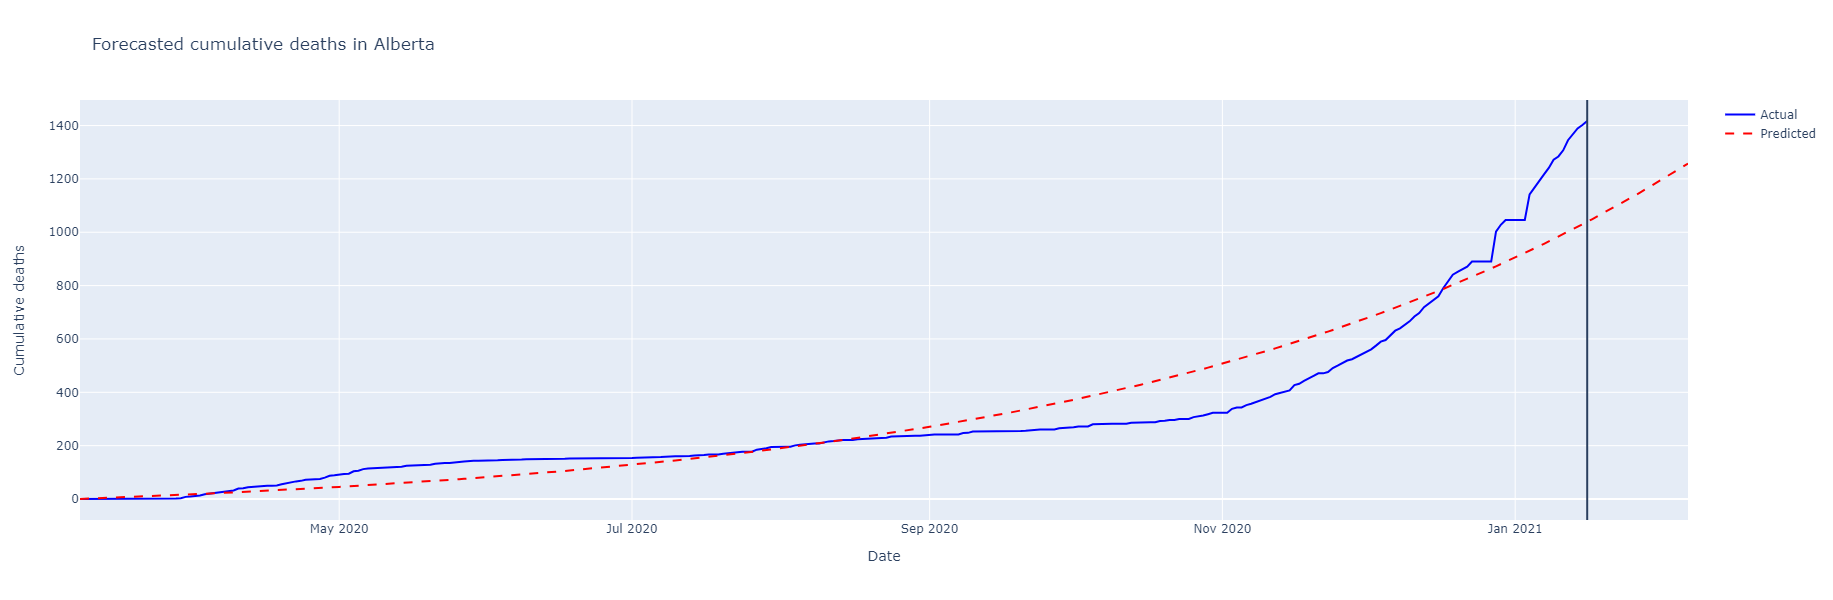

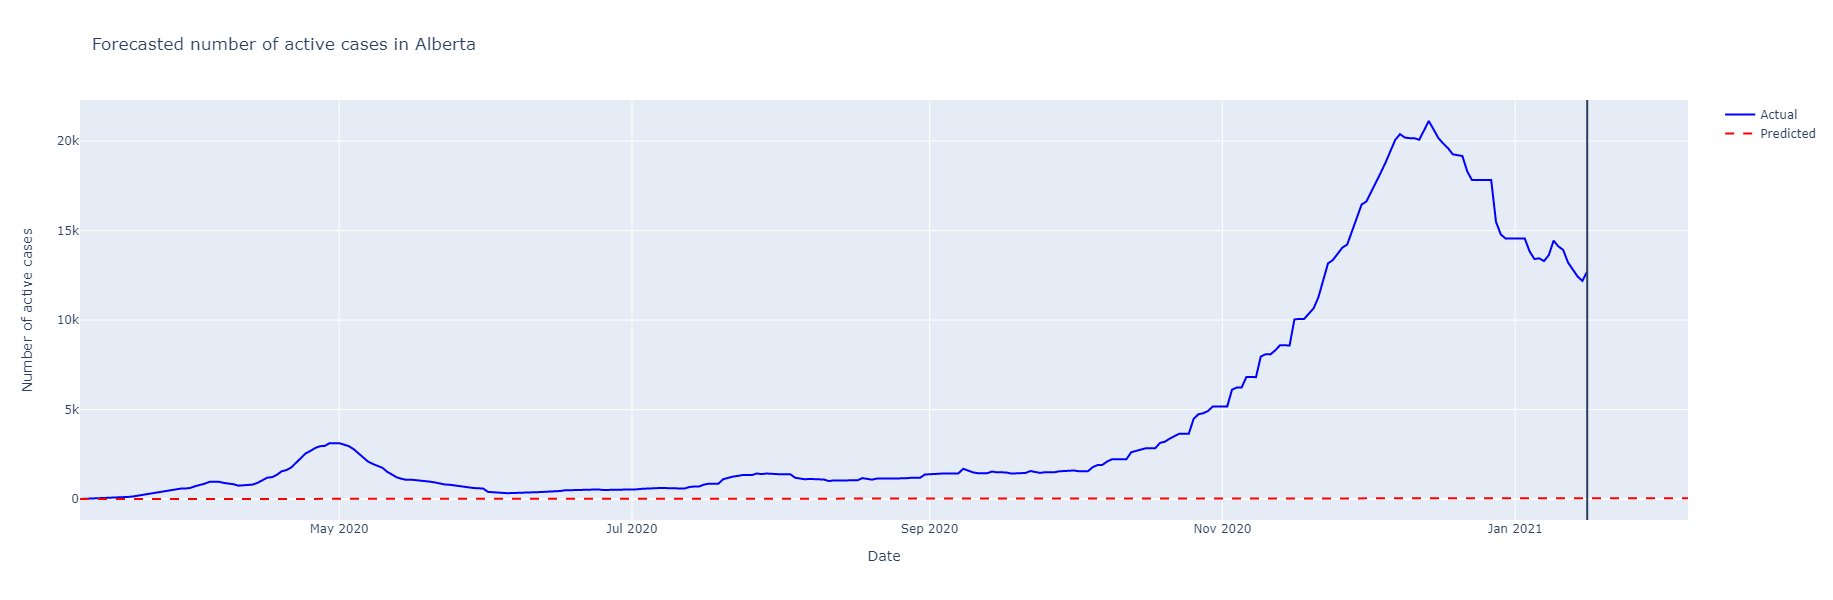

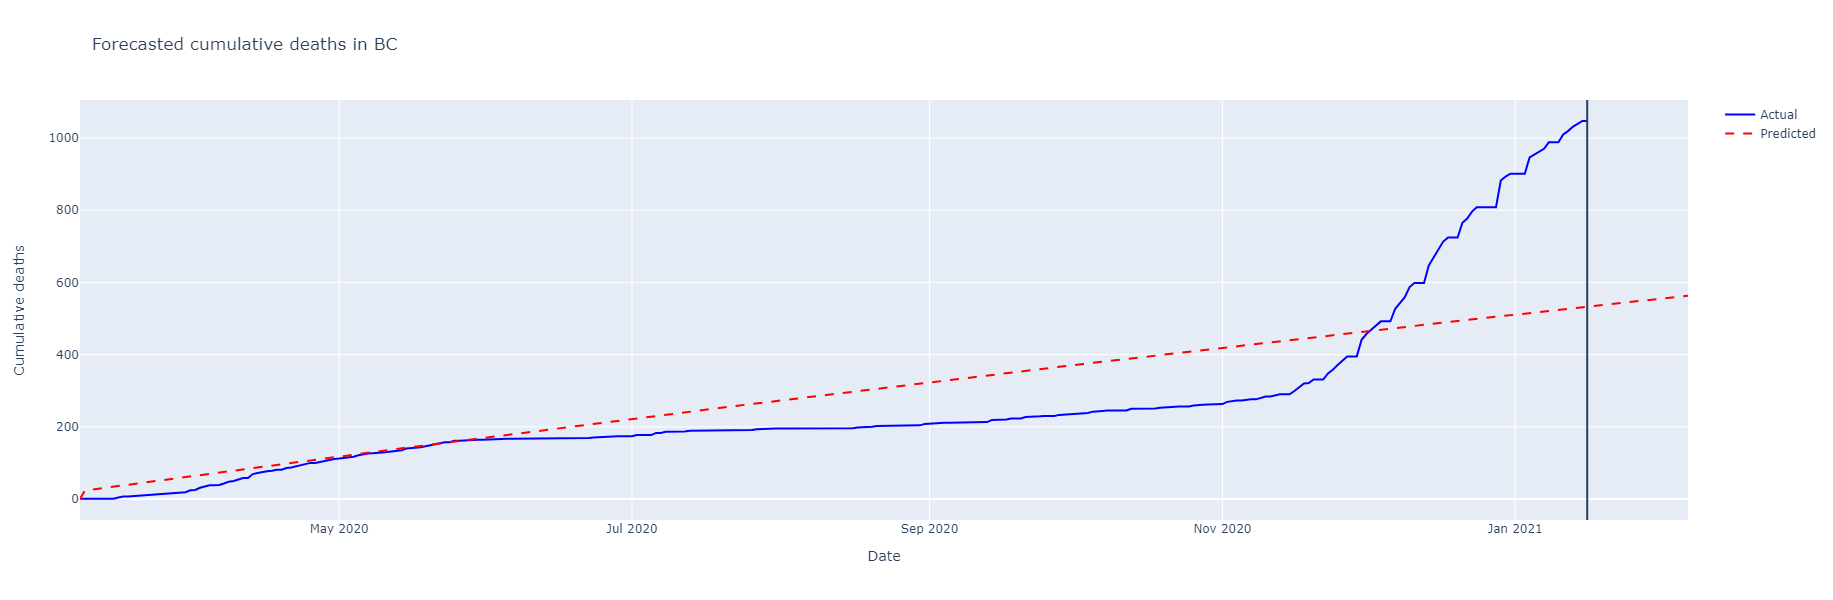

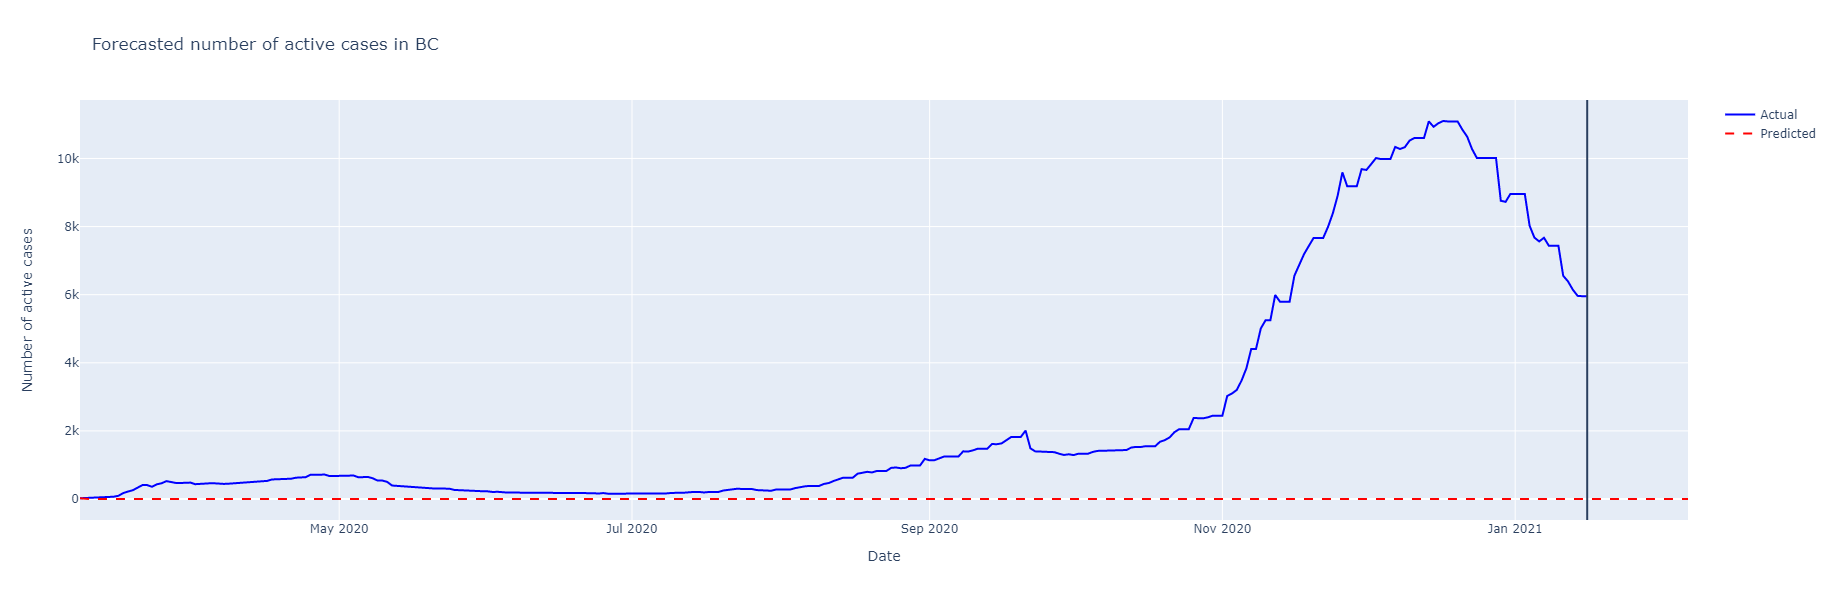

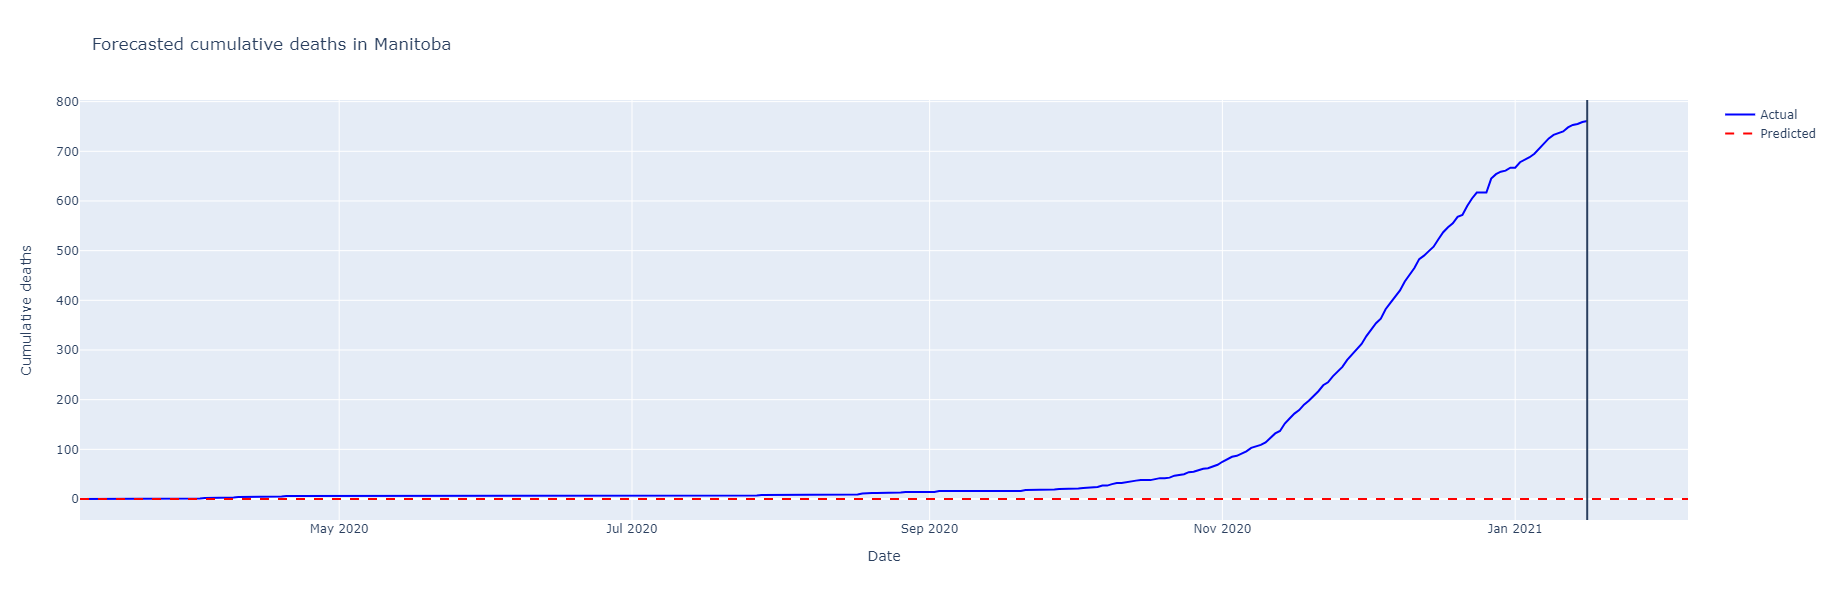

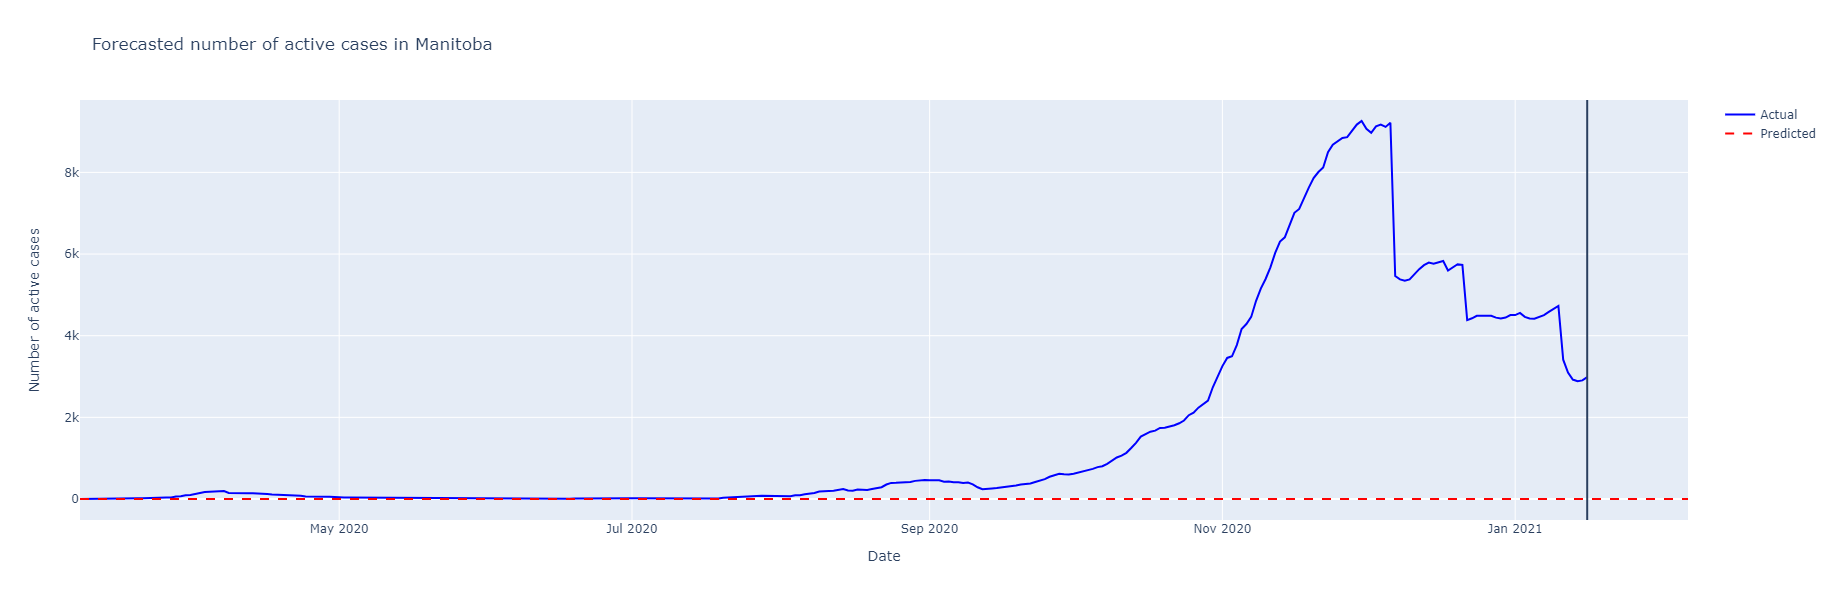

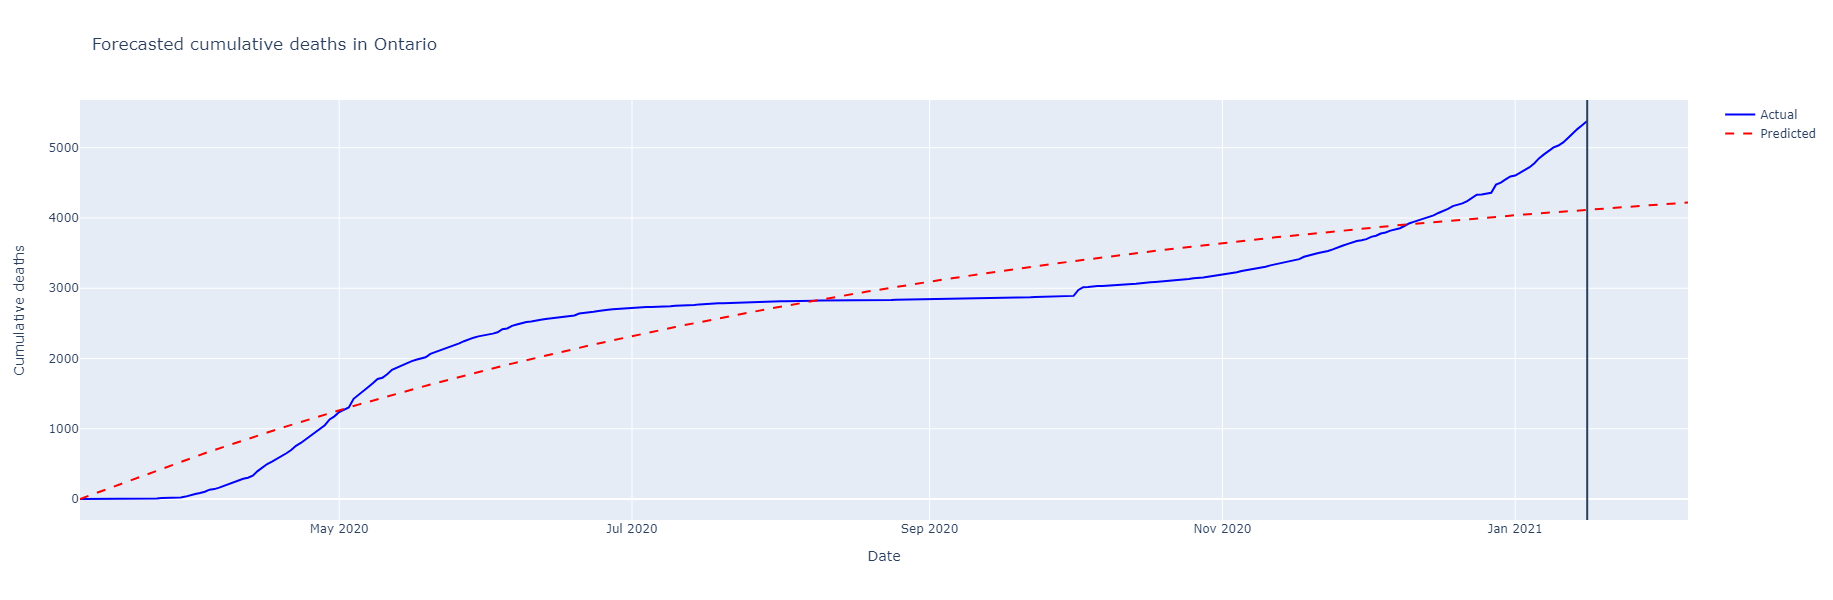

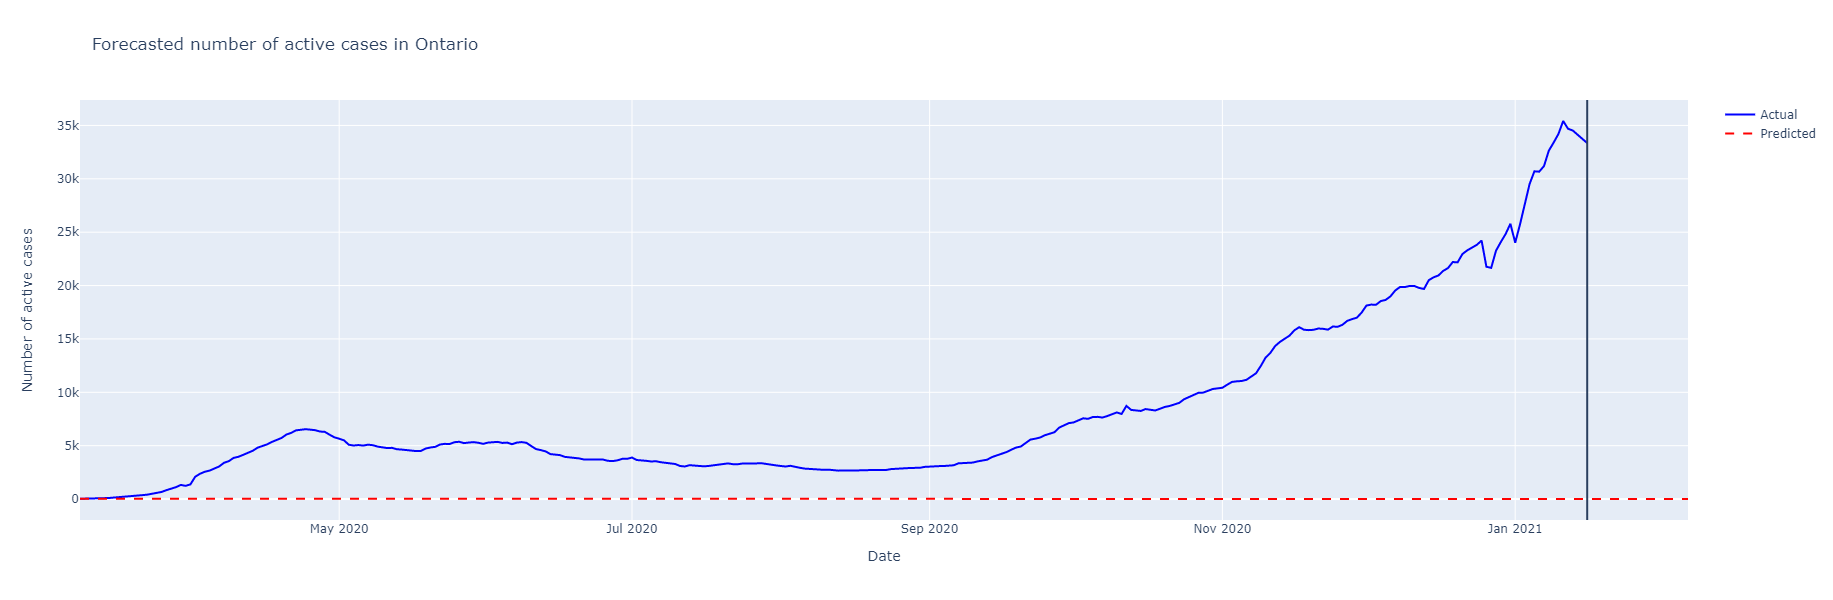

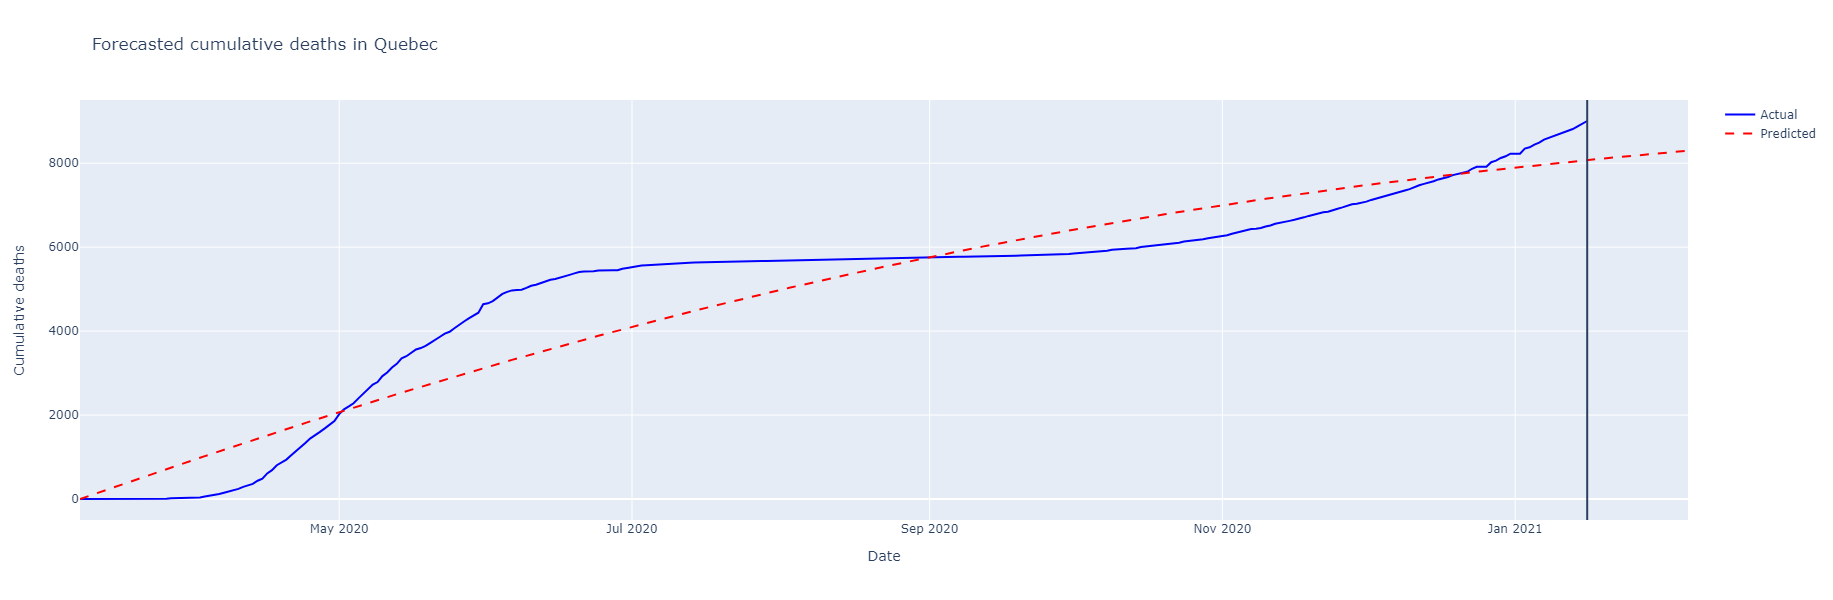

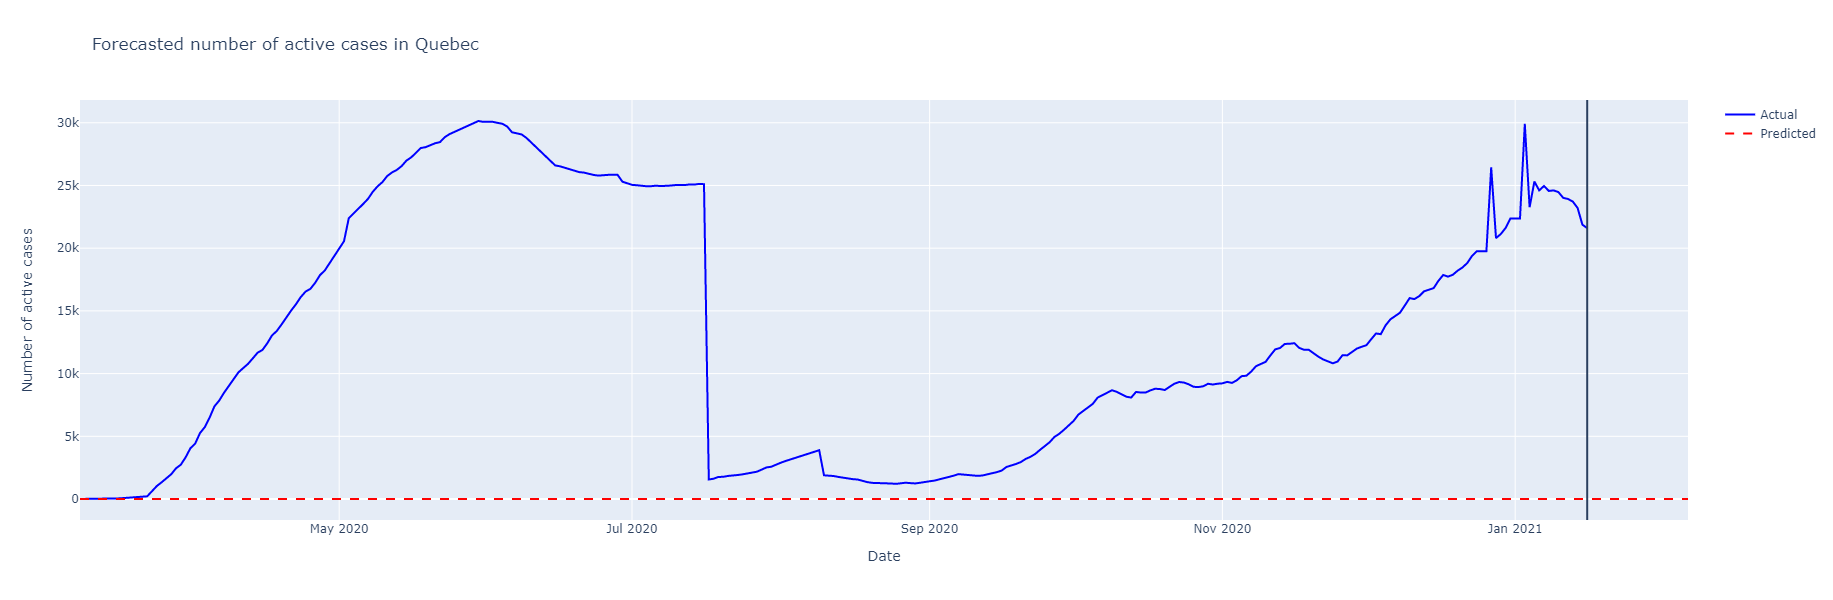

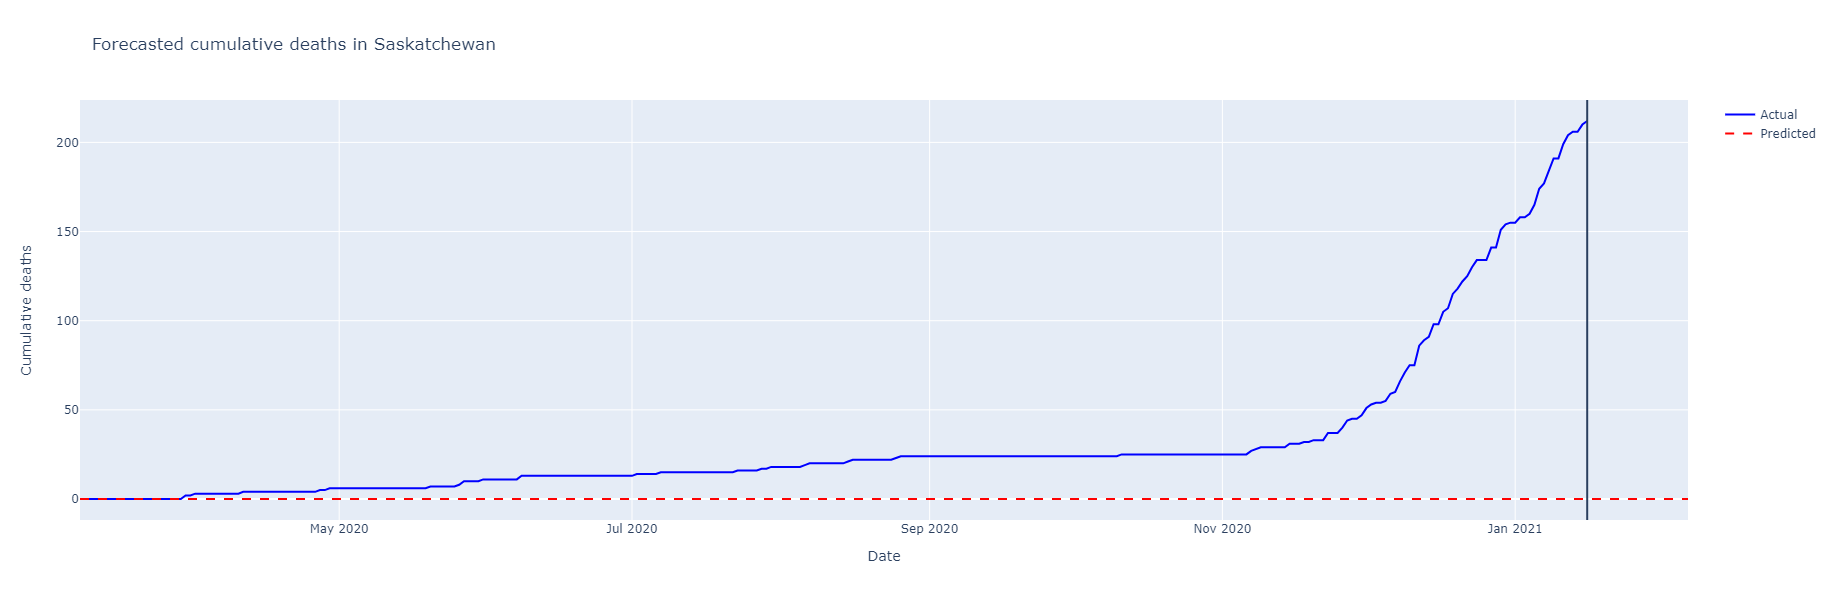

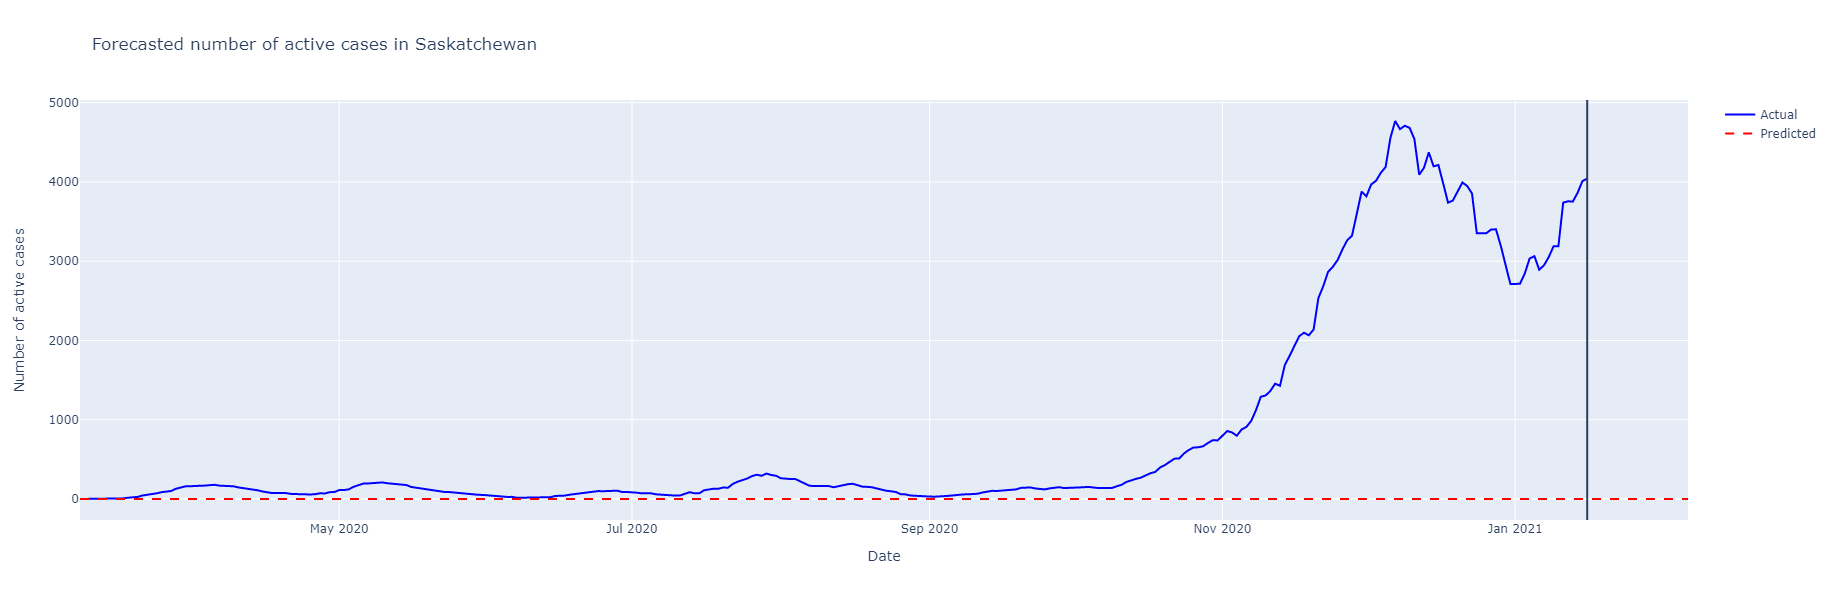

In [90]:
# Prediction plots for all provinces
for province in provinces:
    province_forecasts = forecasts.query("province == @province")

    plot_predictions(
        province_forecasts,
        y="cumulative_deaths",
        y_label="Cumulative deaths",
        title=f"Forecasted cumulative deaths in {province}",
        height=600,
        include_ci=False,
    )

    plot_predictions(
        province_forecasts,
        y="active_cases",
        y_label="Number of active cases",
        title=f"Forecasted number of active cases in {province}",
        height=600,
    )

## SEIR model parameter estimation with time varying parameters

In this variation we allow the parameter $\beta$ which controls the movement of compartment S to E to vary with time. This allows to the SEIR to model the data under changing policies and is more realistic to allow changing rates of infections at different points in time.

In [107]:
%%time

# Fit model and get 3 week forecasts for each province for every province
h = 21
forecasts = pd.DataFrame()

date_splits = [date(year=2020, month=3, day=8), date(year=2020, month=6, day=1), date(year=2020, month=9, day=1), date(year=2020, month=12, day=15), date(year=2021, month=1, day=3)]

for province in provinces:
    # Get province data
    province_data = covid_data.query('province == @province')

    # Fit SEIR model
    model = SEIRModel(lam=1, method = 'L-BFGS-B', date_splits = date_splits, verbose=True)
    model.fit(province_data)    
    
    # Get forecasts
    province_forecasts = model.forecast(h=h)
    forecasts = pd.concat([forecasts, province_forecasts], ignore_index=True)

Wall time: 5min 44s


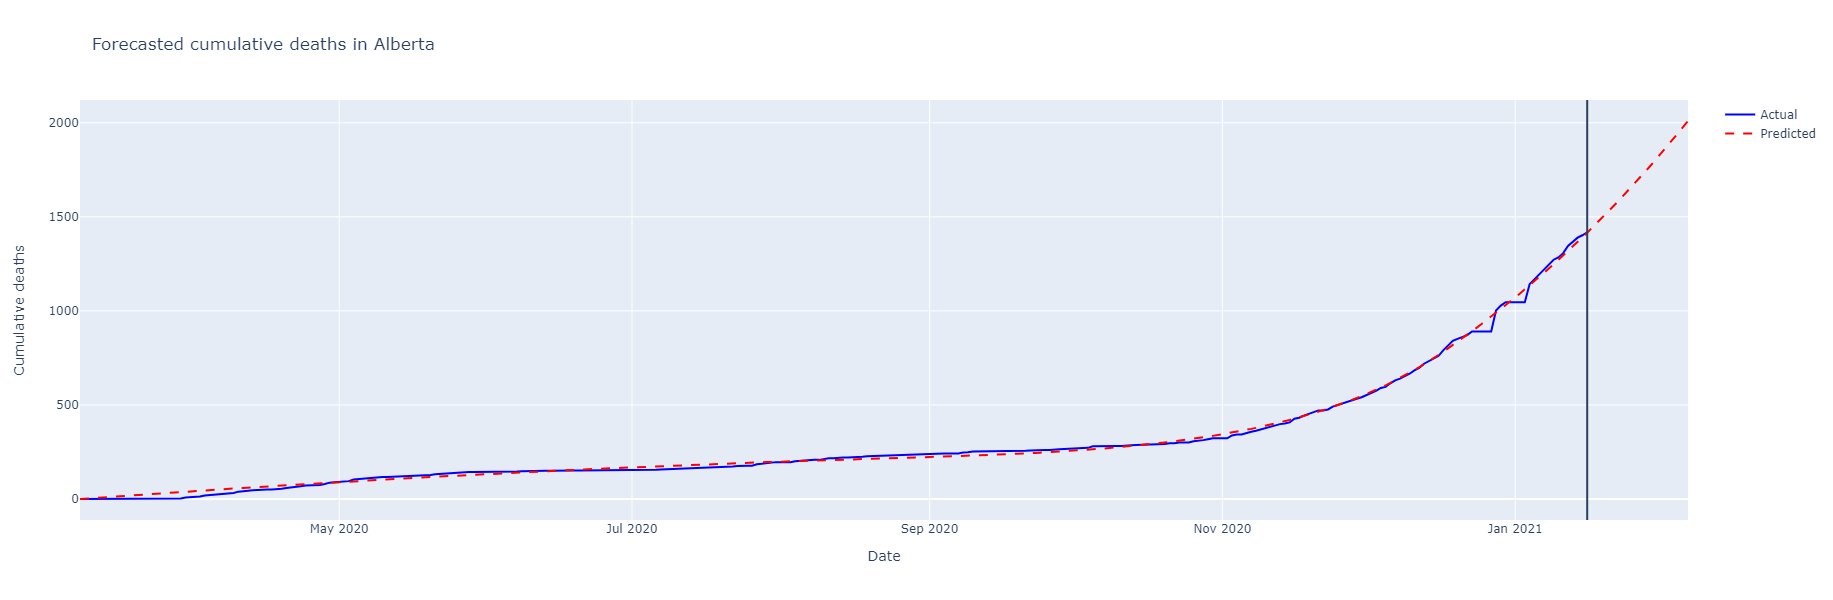

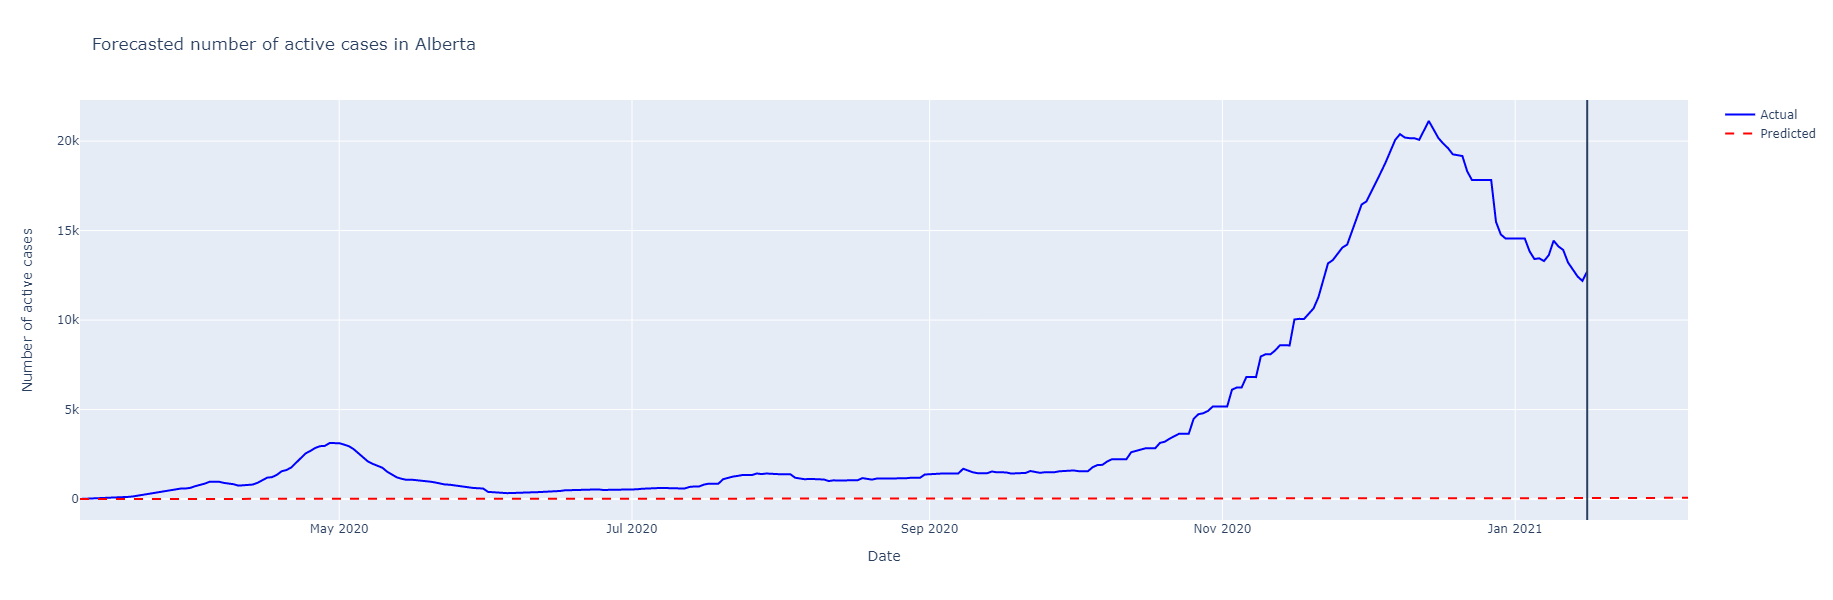

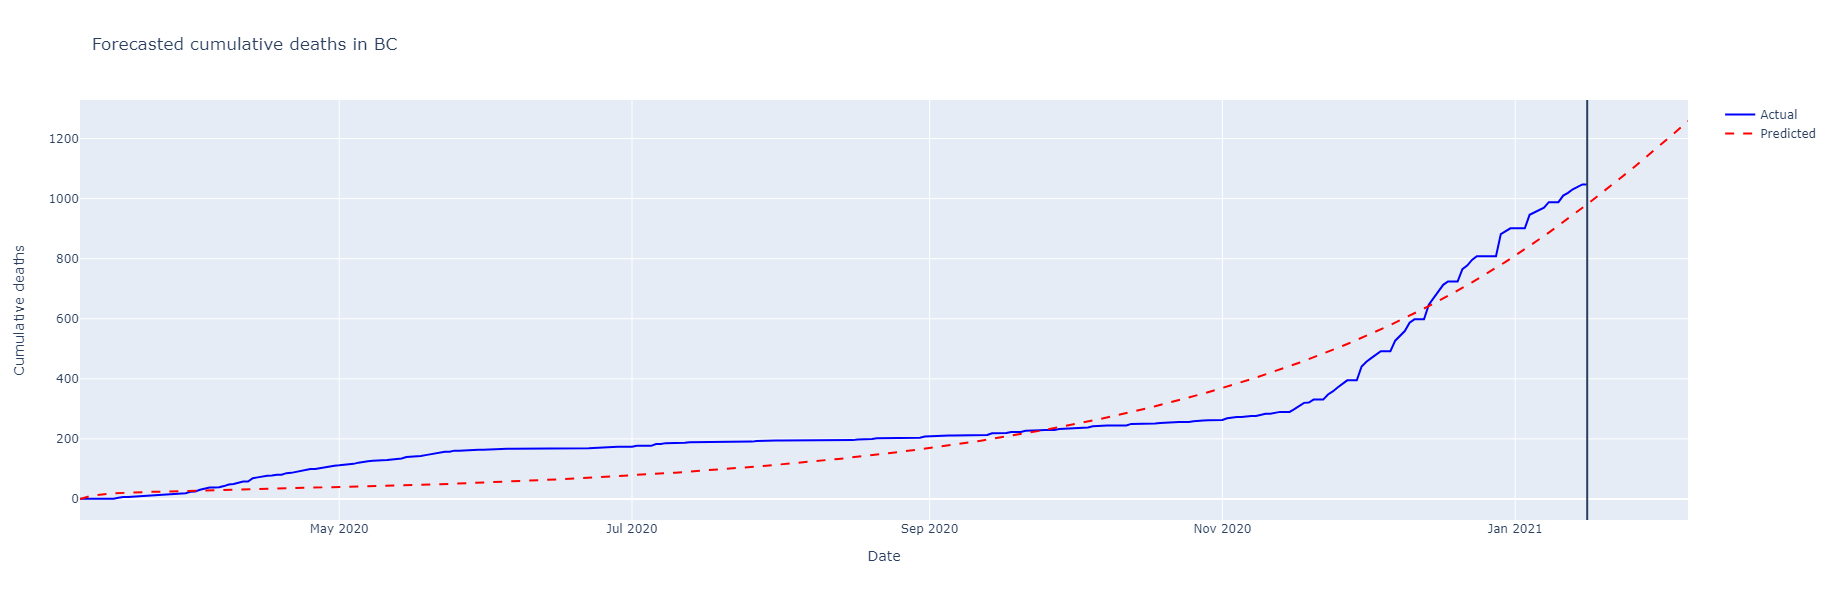

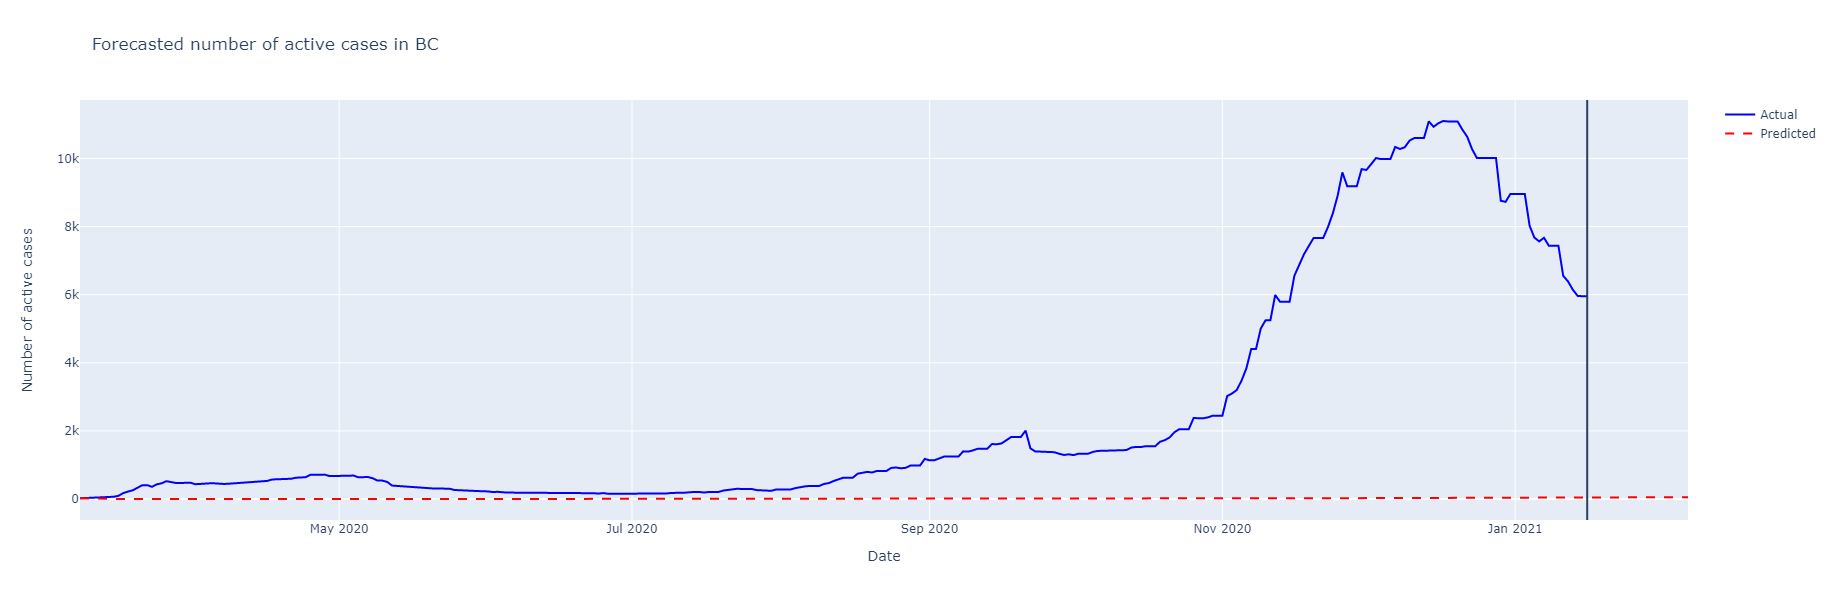

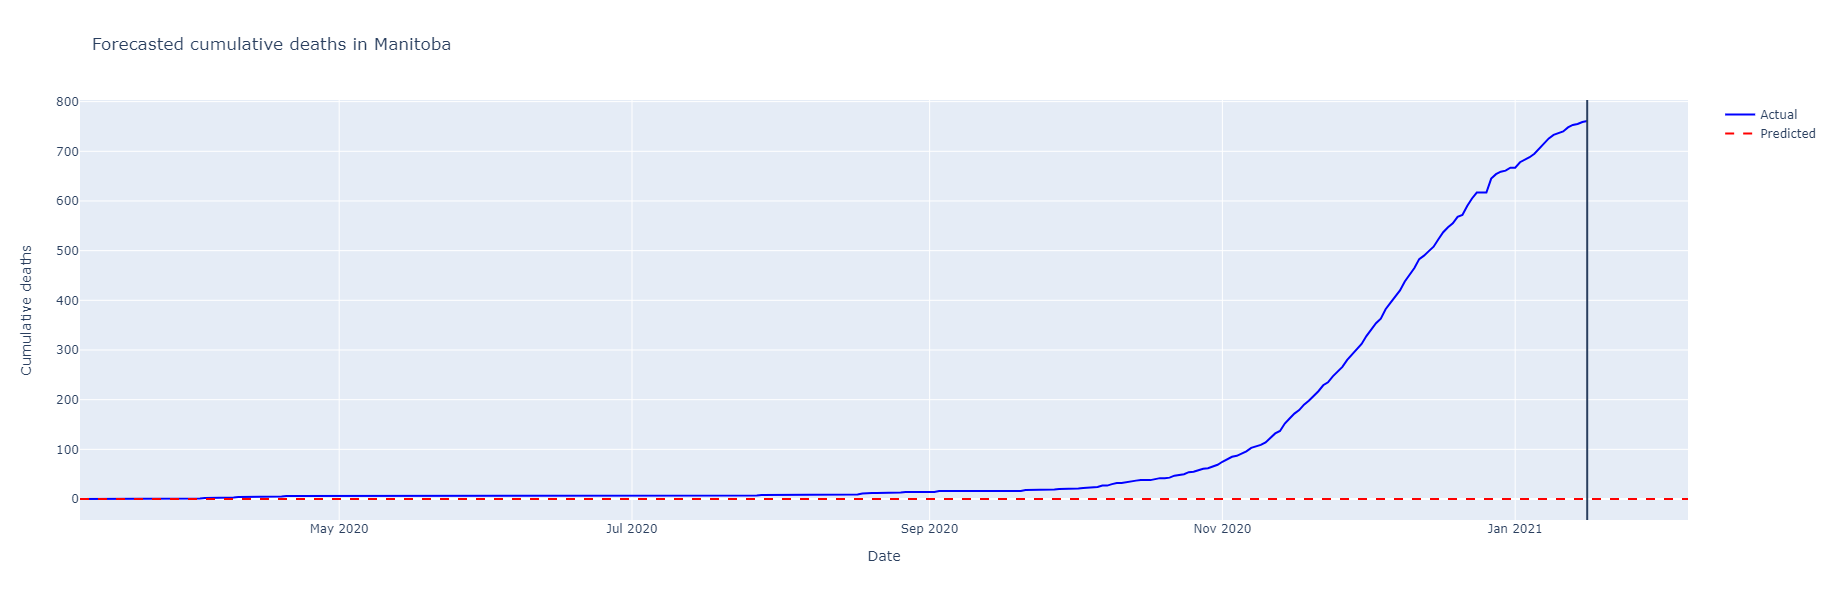

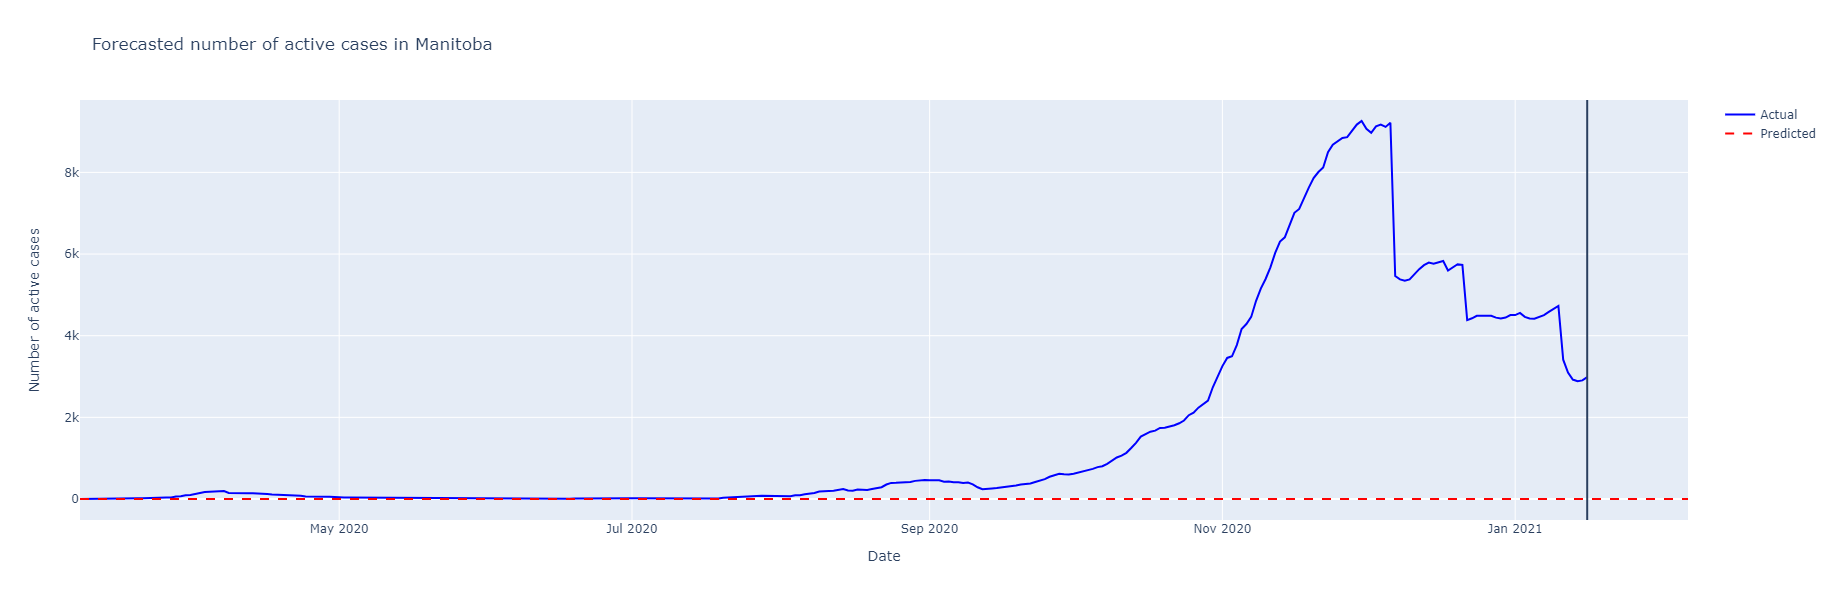

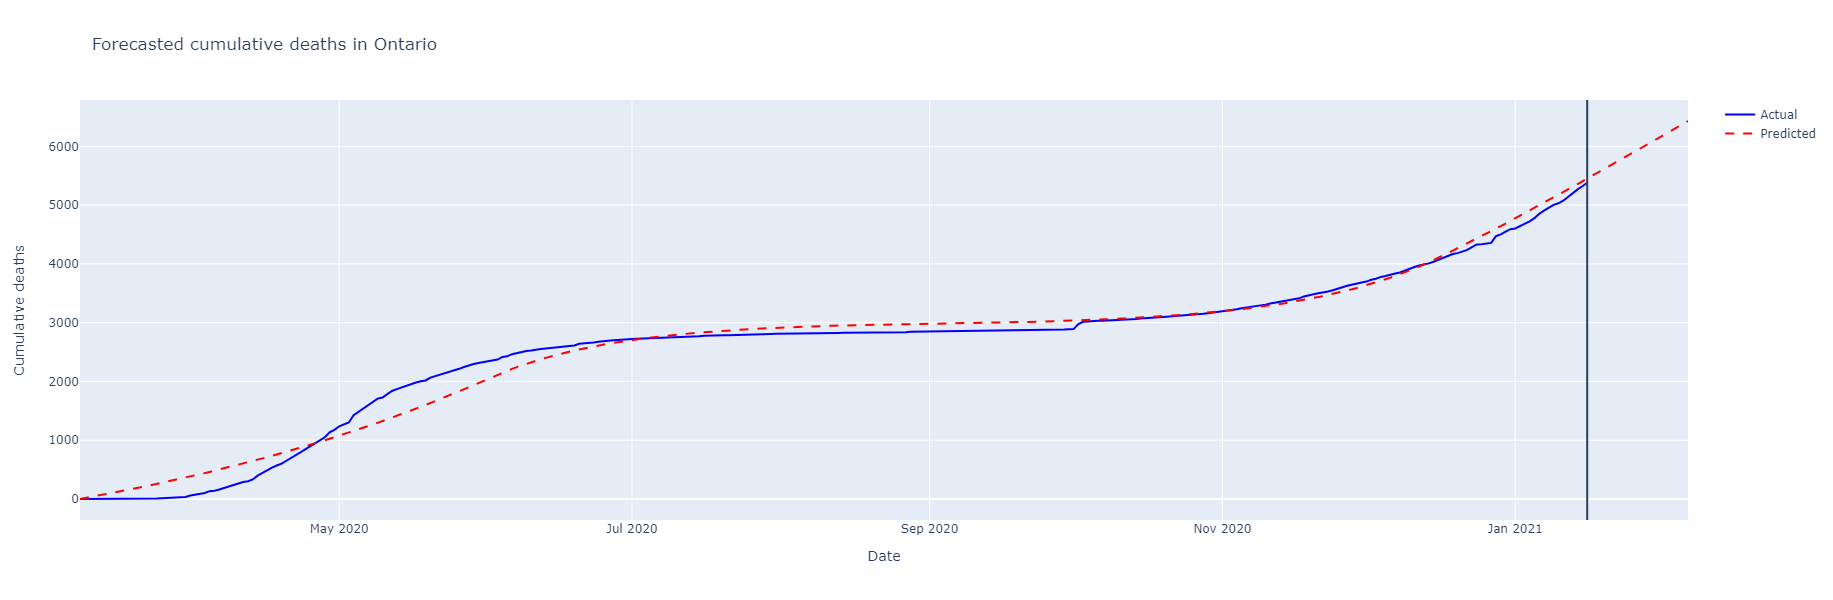

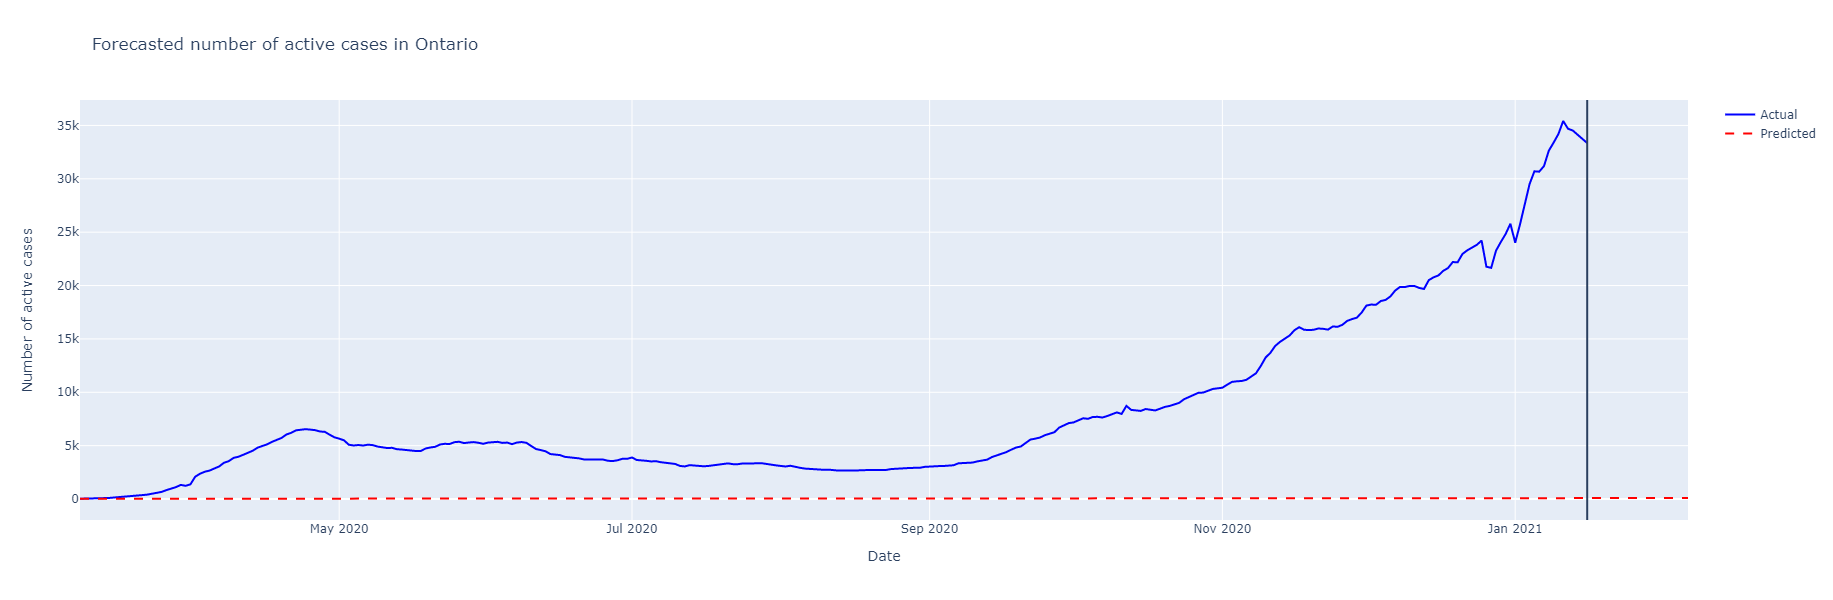

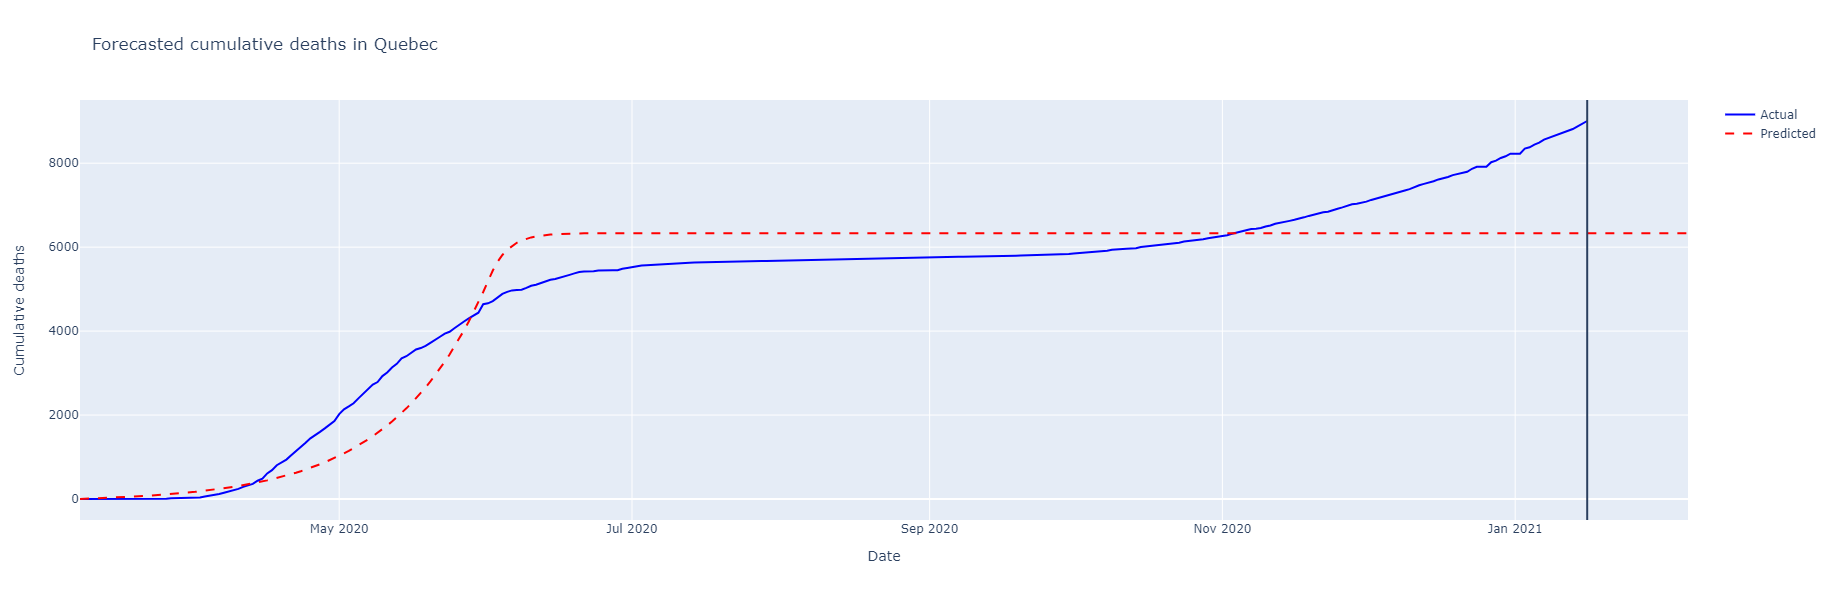

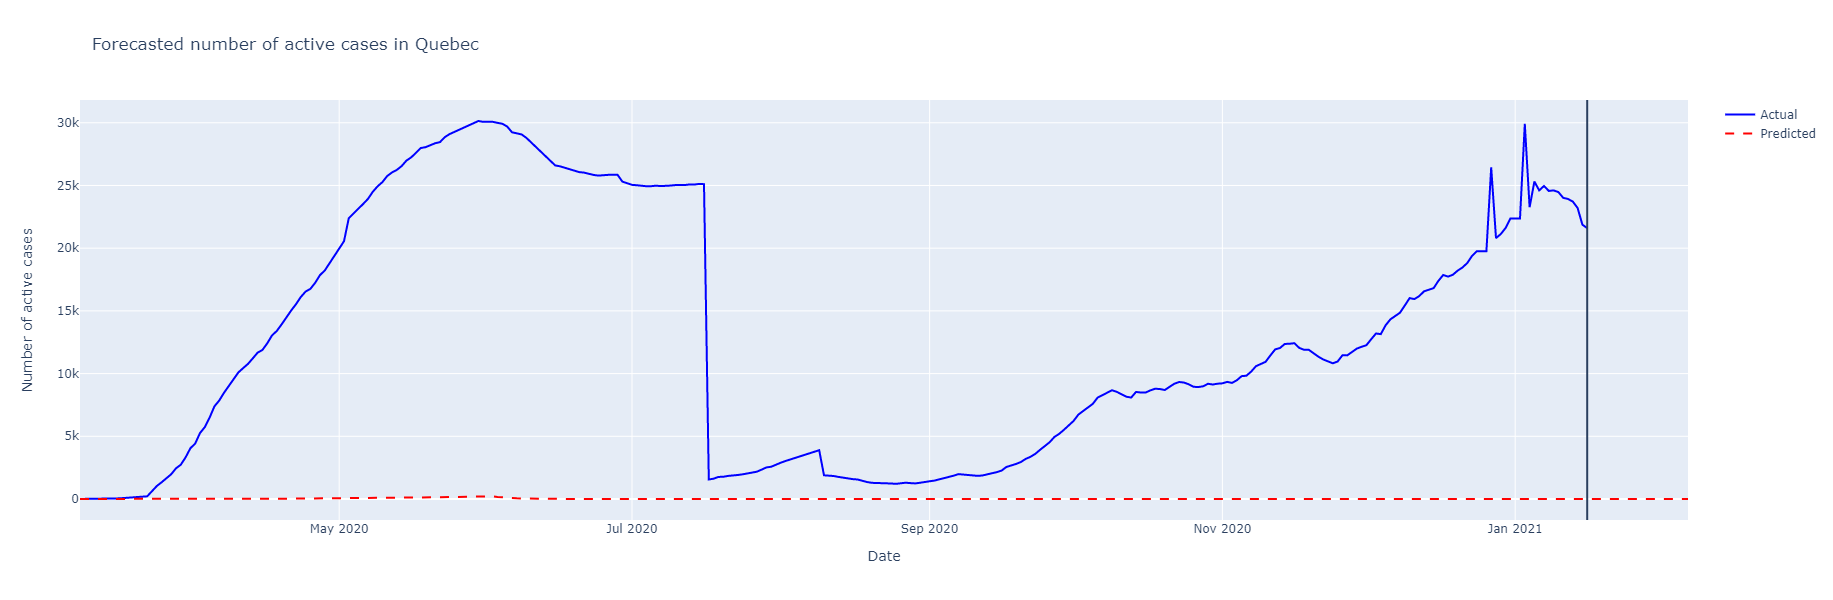

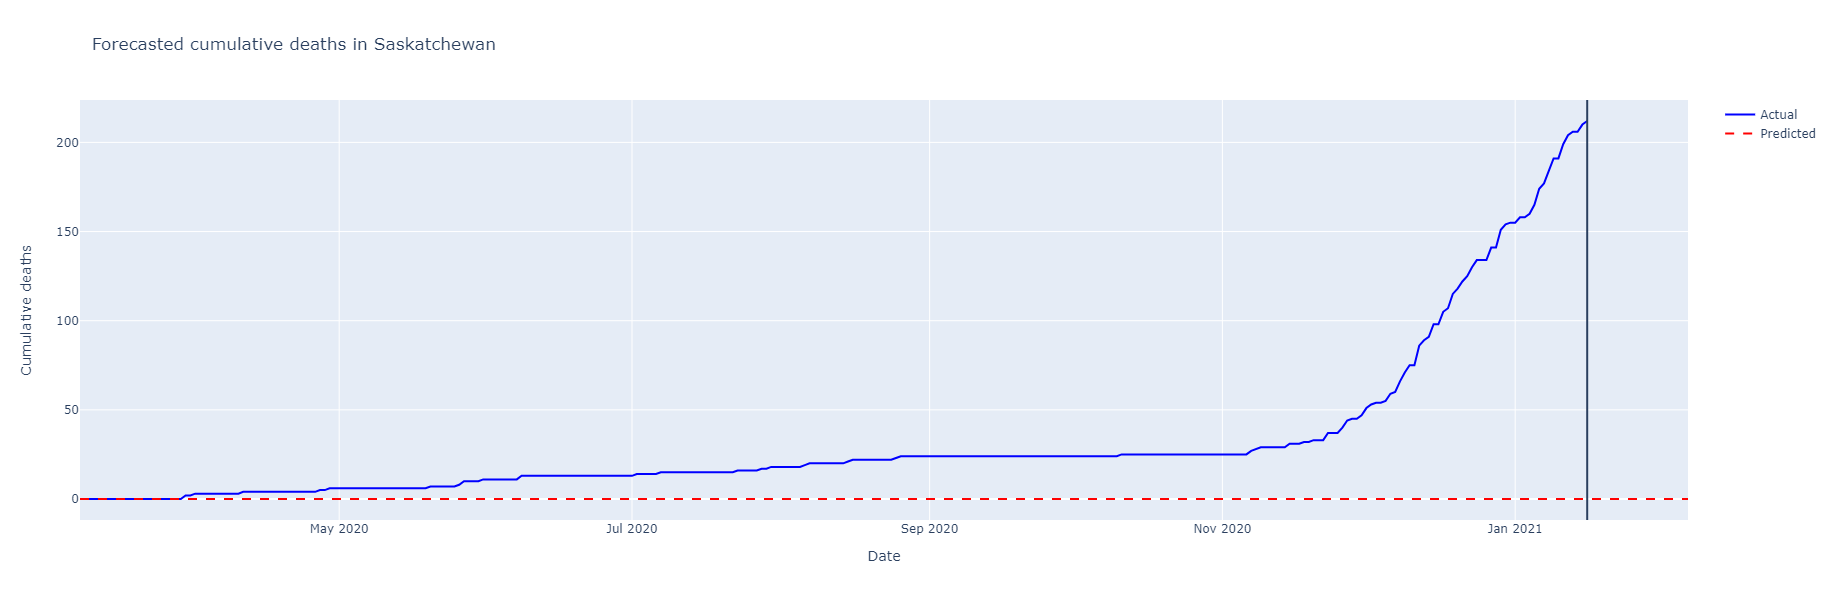

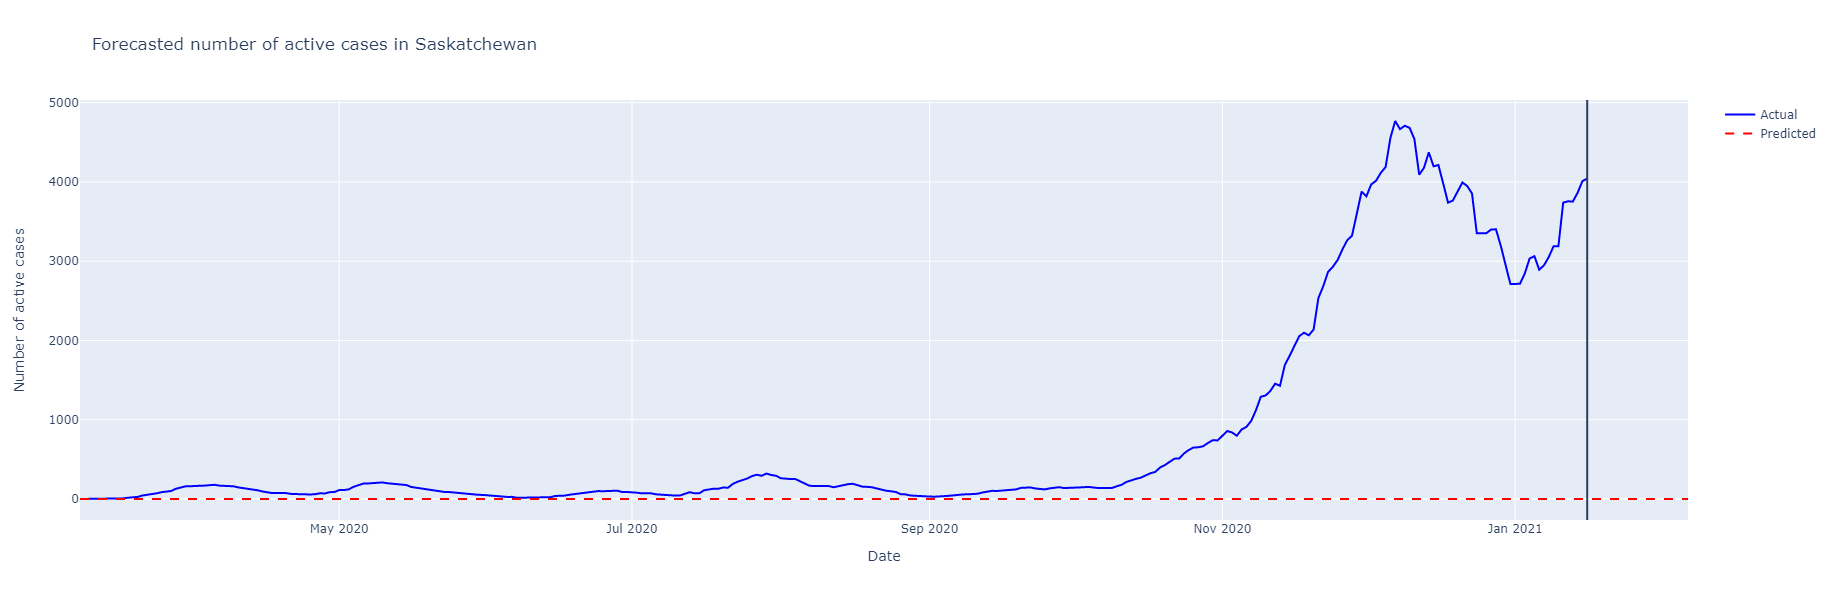

In [108]:
# Prediction plots for all provinces
for province in provinces:
    province_forecasts = forecasts.query("province == @province")

    plot_predictions(
        province_forecasts,
        y="cumulative_deaths",
        y_label="Cumulative deaths",
        title=f"Forecasted cumulative deaths in {province}",
        height=600,
        include_ci=False,
    )

    plot_predictions(
        province_forecasts,
        y="active_cases",
        y_label="Number of active cases",
        title=f"Forecasted number of active cases in {province}",
        height=600,
    )